In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import glob
import math
import csv
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from numpy.linalg import eig, inv
from scipy.spatial import ConvexHull
%matplotlib inline


In [2]:
#Main reference http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html
class Ellipse():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parfit = self.fitEllipse(self.x, self.y)
        self.center = self.ellipse_center()
        self.rotation1 = self.ellipse_angle_of_rotation()
        self.axis_length = self.ellipse_axis_length()
        self.area = self.ellipse_area()
        self.rotation2 = self.ellipse_angle_of_rotation2()
        
    def fitEllipse(self, x, y):
        x = x[:,np.newaxis]
        y = y[:,np.newaxis]
        D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
        S = np.dot(D.T,D)
        C = np.zeros([6,6])
        C[0,2] = C[2,0] = 2; C[1,1] = -1
        E, V =  eig(np.dot(inv(S), C))
        n = np.argmax(np.abs(E))
        a = V[:,n]
        return a

    def ellipse_center(self):
        b,c,d,f,g,a = self.parfit[1]/2, self.parfit[2], self.parfit[3]/2, self.parfit[4]/2, self.parfit[5], self.parfit[0]
        num = b*b-a*c
        x0=(c*d-b*f)/num
        y0=(a*f-b*d)/num
        return np.array([x0,y0])


    def ellipse_angle_of_rotation(self):
        b,c,d,f,g,a = self.parfit[1]/2, self.parfit[2], self.parfit[3]/2, self.parfit[4]/2, self.parfit[5], self.parfit[0]
        return 0.5*np.arctan(2*b/(a-c))


    def ellipse_axis_length(self):
        b,c,d,f,g,a = self.parfit[1]/2, self.parfit[2], self.parfit[3]/2, self.parfit[4]/2, self.parfit[5], self.parfit[0]
        up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
        down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
        down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
        res1=np.sqrt(up/down1)
        res2=np.sqrt(up/down2)
        return np.array([res1, res2])

    def ellipse_area(self):
        '''author: alebaal'''
        return np.pi*np.product(self.axis_length)

    def ellipse_angle_of_rotation2(self):
        b,c,d,f,g,a = self.parfit[1]/2, self.parfit[2], self.parfit[3]/2, self.parfit[4]/2, self.parfit[5], self.parfit[0]
        if b == 0:
            if a > c:
                return 0
            else:
                return np.pi/2
        else:
            if a > c:
                return np.arctan(2*b/(a-c))/2
            else:
                return np.pi/2 + np.arctan(2*b/(a-c))/2

In [3]:
class Slab(Ellipse):
    def __init__(self, slab, nmol):
        self.slab = slab
        self.nmol = nmol
        self.hull = ConvexHull(self.slab, qhull_options='Qi')
        self.hullPoints = self.slab[self.hull.vertices]
        Ellipse.__init__(self, self.hullPoints[:,0], self.hullPoints[:,1])
  

In [4]:
class Profiles():
    def __init__(self, N, h, L, S):
        #total Water molecules
        self.N = N
        #height        
        self.h = h
        #Simulation Box
        self.L = L
        #Slab thickness
        self.S = S
        #water density box        
#        self.rho = np.zeros((int(self.h/self.S), int(self.L/self.S), int(self.L/self.S))) Not in use, check
        self.listProfiles = []
        self.Oatoms = None
        
    def addProfile(self, path):
        self.getOxygenPos(path) 
        self.correctBoardEffect()
        self.removeOutMolecules()
        self.listProfiles.append(self.findProfile()) 
         
    def getOxygenPos(self, file): 
        '''
        sets the Oxigen positions
        '''
        rawData = np.genfromtxt(file,dtype="float",skip_header=9)
        self.Oatoms = rawData[np.where(rawData[:,1]==2)][:,2:] 

    def getsCM(self):
        '''
        Calculates the Center of Mass
        '''
        return np.sum(self.Oatoms, axis=0)/self.N

    def correctBoardEffect(self):
        '''
        Fix the boarder problem and calculate the CM
        '''
        CM = self.getsCM()
        OatomsFix = self.Oatoms
        OatomsFix[:,1:] -= CM[1:]

        Oatoms_out_index  = np.where(abs(OatomsFix[:,1]) > self.L/2)
        Oatoms_out_index2 = np.where(OatomsFix[Oatoms_out_index] > 0)
        OatomsFix[Oatoms_out_index2] -= self.L 
        Oatoms_out_index3 = np.where(OatomsFix[Oatoms_out_index] < 0)
        OatomsFix[Oatoms_out_index3] += self.L 

        Oatoms_out_index  = np.where(abs(OatomsFix[:,2]) > self.L/2)
        Oatoms_out_index2 = np.where(OatomsFix[Oatoms_out_index] > 0)
        OatomsFix[Oatoms_out_index2] -= self.L 
        Oatoms_out_index3 = np.where(OatomsFix[Oatoms_out_index] < 0)
        OatomsFix[Oatoms_out_index3] += self.L 

        OatomsFix[:,1:] += CM[1:]

    #    CM = self.getsCM() #Check this line. Maybe it is before Oatoms
        self.Oatoms = OatomsFix


    def removeOutMolecules(self):
        '''
        Remove water molecules out from bridge
        '''
        mask = np.sqrt(np.sum(self.Oatoms[:, 1:]**2, axis=1)) > 45.0
        self.Oatoms = self.Oatoms[~mask]


    def findProfile(self):
        '''
        Fitting a ellipse for each profile
        '''
        #get atoms position from histogram
        hist_count, bins_edges = np.histogramdd(self.Oatoms, bins =(int(self.h/self.S), int(self.L/self.S), int(self.L/self.S)), range = ((-self.h/2,self.h/2), (-self.L/2,self.L/2), (-self.L/2,self.L/2)))
        bins_posY = (bins_edges[1][1:] - bins_edges[1][:-1])/2 + bins_edges[1][:-1]
        bins_posZ = (bins_edges[2][1:] - bins_edges[2][:-1])/2 + bins_edges[2][:-1]
        grid = []
        for y in bins_posY:
            temp = []
            for z in bins_posZ:
                temp.append([y,z])
            grid.append(temp)
        grid = np.array(grid)    

        pointsProfile = []
        nSlabs = 5
    #Loop: 1) Colappse the O atoms inside 5A slabes into a plane, which is a cross section of the bridge

        for i in range(0,len(hist_count), nSlabs):

            #here I am collapsing five slabs into one
            points_cross_section = np.sum(hist_count[i:i+nSlabs], axis=0)

            #here I am finding the filled cells
            mask = points_cross_section > 0    

            #finding the cells positions and creating points coordinates
            px, py =  np.split(grid[mask], 2, axis = 1)
            px = px.flatten()
            py = py.flatten()
            pointsCH = np.stack((px,py), axis=-1)
            pointsProfile.append(Slab(pointsCH, points_cross_section.sum()))
        return pointsProfile


In [5]:
class Analysis(Profiles):
    def __init__(self, N, h, L, S, path):
        self.path = path
        Profiles.__init__(self, N, h, L, S)
        self.filesPos = sorted(glob.glob(self.path))
        #Analised Profiles

        
    def loop(self):        
        '''Loop to read configurations'''
        if not self.listProfiles:
            count = 0
            for fileConfig in self.filesPos:
                self.addProfile(fileConfig)
                if(count/1000000):
                    print("Analysing " + fileConfig)                    
        else:
            print("The configuration files " + self.path + " have already been analysed.")
            
           
    def plotSlab(self, slab, pos):
        cmap = matplotlib.cm.get_cmap('hsv')
        plt.figure(figsize=(10,10))
        plt.ylim(-self.L,self.L)
        plt.xlim(-self.L,self.L)

        arc = 2
        R = np.arange(0,arc*np.pi, 0.01)
        center = self.listProfiles[pos][slab].center
        phi = self.listProfiles[pos][slab].rotation2
        axes = self.listProfiles[pos][slab].axis_length

        a, b = axes
        xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
        yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)

        plt.scatter(self.listProfiles[pos][slab].slab[:,0], self.listProfiles[pos][slab].slab[:,1],  color='grey', s=10, marker='o')
        
        plt.scatter(self.listProfiles[pos][slab].x, self.listProfiles[pos][slab].y,  color='b', s=20, marker='o')

        #plt.plot(pointsCH[hull.vertices[0],0], pointsCH[hull.vertices[0],1], 'ro')
        plt.plot(xx,yy, color = 'r', label = 'slab %d' % (slab))
        plt.legend()    
        plt.savefig('./find_ellipse_All_profile_s' + str(slab) + 'p' + str(pos) + '.png')
        
    def plotPar(self):
        
        

        nMolsSlab = {'base':list(), 'top':list()}
        areaSlab = {'base':list(), 'top':list()}
        
        for i in self.listProfiles:
            nMolsSlab['base'].append(i[-1].nmol)
            areaSlab['base'].append(i[-1].area) 
            nMolsSlab['top'].append(i[0].nmol)
            areaSlab['top'].append(i[0].area) 
        
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
        ax1.plot(range(len(nMolsSlab['base'])),nMolsSlab['base'], label = 'base', color = 'k')
        ax1.plot(range(len(nMolsSlab['top'])),nMolsSlab['top'], label = 'top', color = 'r')
        ax1.set_ylabel('nMolecules')
        ax1.set_xlabel('time (1000 fs)')
        ax1.legend(loc = 'upper right')
        
        ax2.plot(range(len(areaSlab['base'])), areaSlab['base'], label = 'base', color = 'k')
        ax2.plot(  range(len(areaSlab['top'])), areaSlab['top'], label = 'top', color = 'r')
        ax2.set_ylabel('Area')
        ax2.set_xlabel('time (1000 fs)')
        ax2.legend(loc = 'upper right')        
        plt.savefig('./analysisAreaAndNumWaterMolecules.png')
#         for i in range(len(fitEllipseProfile) ):
#         #for i in [0]:
#             arc = 2
#             R = np.arange(0,arc*np.pi, 0.01)
#             center = ellipse_center(fitEllipseProfile[i])
#             phi = ellipse_angle_of_rotation2(fitEllipseProfile[i])
#             axes = ellipse_axis_length(fitEllipseProfile[i])

#             a, b = axes
#             xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
#             yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)

#             plt.scatter(pointsProfile[i][:, 0], pointsProfile[i][:, 1],  color='grey', s=10, marker='o')
#             plt.scatter(pointsProfile[i][hullData[i].vertices, 0], pointsProfile[i][hullData[i].vertices, 1],  color='b', s=20, marker='o')

#             #plt.plot(pointsCH[hull.vertices[0],0], pointsCH[hull.vertices[0],1], 'ro')
#             plt.plot(xx,yy, color = cmap(i/10), label = 'slab %d' % (i))
#         plt.legend()    
#         plt.savefig('./find_ellipse_All_profile2.png')

In [6]:
teste = Analysis(3375, 50.0, 70, 1, '/home/alebaal/Documents/thermoCapillarywaves/moviment-3-cont/*0000.pos.gz')

In [7]:
teste.loop()

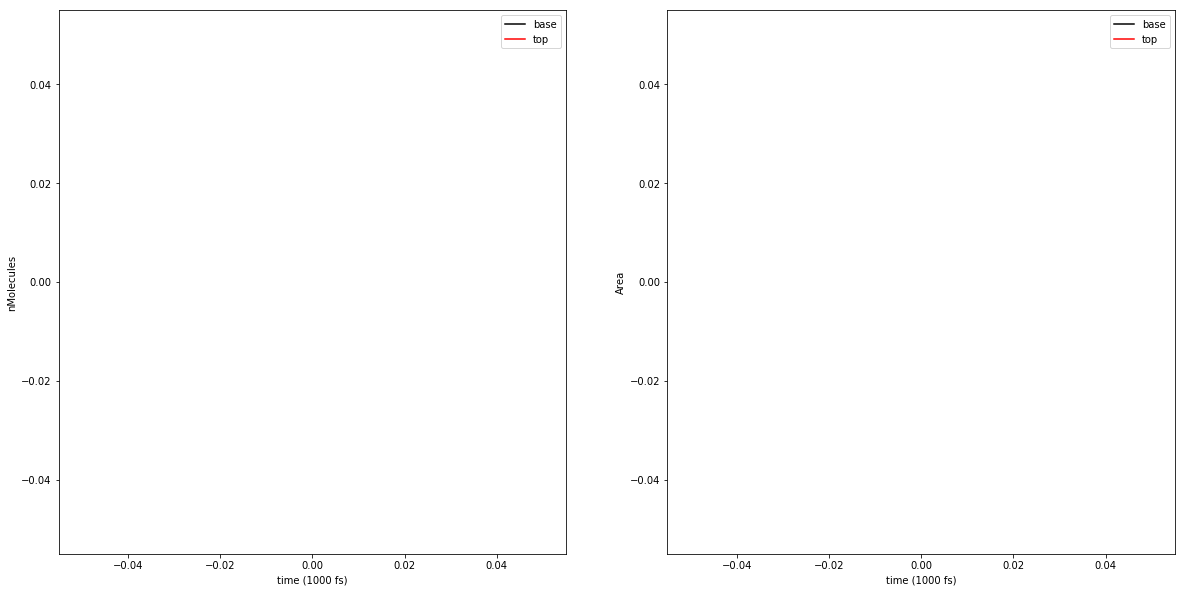

In [8]:
teste.plotPar()

In [9]:
hist_count, bins_edges = np.histogramdd(([np.random.normal(size = 100),np.random.normal(size = 100),np.random.normal(size = 100)]), bins =(5,5,5), range = ((-1,1), (-1,1), (-1,1)))


In [10]:
teste.listProfiles[0][0].nmol

IndexError: list index out of range

In [ ]:
teste.plotSlab(0,0)